#  <u> 1st step : Load

First we open the merged table with the 6 indicators that we have created in the 'Load part'

We import the different librairies that we are going to use :

    - pandas : Pandas is a library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical arrays and time series.
    
    - functools : The functools module is for higher-order functions: functions that act on or return other functions. In general, any callable object can be treated as a function for the purposes of this module
    
    -  Matplotlib is a Python programming language library for plotting and visualizing data as graphs.

In [237]:
# we import the useful librairies 
import pandas as pd
import functools
import matplotlib.pyplot as plt
import numpy as np

Then we open and read the merged table of all indicators

In [238]:
# we open and read the merged table of all indicators
bronze_dataset = pd.read_csv ('./data/all_indicators_table.csv')
bronze_dataset = bronze_dataset.drop(bronze_dataset.columns[0], axis = 1)
bronze_dataset = bronze_dataset.drop(bronze_dataset.columns[0], axis = 1)

 and Then we put all the indicators in only one column 

In [239]:
#Then we put all the indicators in only one column 
bronze_dataset=(bronze_dataset.set_index(["Code", "Year"]).stack().reset_index(name='Value').rename(columns={'level_2':'Indicator'})) 
bronze_dataset

,Code,Year,Indicator,Value
0,AFG,1966,Deaths,1.616590e+05
1,AFG,1966,LifeExpectancy,3.550000e+01
2,AFG,1966,GDP,5.000002e+08
3,AFG,1966,Fertility,7.320300e+00
4,AFG,1967,Deaths,1.625790e+05
...,...,...,...,...
66664,ZWE,1945,GDP,4.100000e+07
66665,ZWE,1946,GDP,4.800000e+07
66666,ZWE,1947,GDP,5.900000e+07
66667,ZWE,1948,GDP,7.200000e+07


# <u>STEP 2 : IQR method  
    
For normalizing our data we need to start computing the outliers and removing them from our dataframe. 
    
We are going to realize taht thanks to the IQR method by identifying outliers to set up a “fence” outside of the interqurtile range.   
Any values that fall outside of this fence are considered outliers. 
    

To build the fence we begin with the computation of the quartiles, then the IQR (Inter Quartile Range) and finally the upper and lower limit.

### 1) computing the quartiles :  

Definition :

To understand what are the quartiles you need to divide your data into quarters.   
Each quarter is called in statistics a quartile named  Q1, Q2, Q3, and Q4. 

The lowest quartile (Q1=25%) is the value below which 25% of the data lies   
The upper quartile (Q3=75%) is the value below which 75% of the data lies 

The interquartile range is the difference between the upper quartile and the lower quartile : IQR=Q3-Q1
    

Fisrt we compute the first quartile, the second quartile and the interquartile range 

In [240]:
# 1st quartile 
Q1=bronze_dataset.groupby(['Code','Indicator']).quantile(0.25)

# 3rd quartile 
Q3=bronze_dataset.groupby(['Code','Indicator']).quantile(0.75)

#interquartile range 
IQR=Q3-Q1

IQR

Year         Value
Code Indicator                             
ABW  Fertility           35.5  1.317100e+00
     GDP                  8.5  3.090634e+08
     LifeExpectancy      35.5  7.025000e+00
AFG  Deaths              27.0  4.707350e+04
     Fertility           35.5  3.561750e-01
...                       ...           ...
ZWE  Fertility           35.5  3.106400e+00
     GDP                 45.5  4.186134e+09
     GenderInequality    15.5  5.250000e-02
     LifeExpectancy      35.5  8.150000e+00
     tertiary_education  20.0  1.080000e+00

[1190 rows x 2 columns]

### 2) computing the limits :

The next step to build the fence is to take 1.5 times the IQR and then subtract this value from Q1 and add this value to Q3.   This gives us the minimum and maximum fence posts that we compare each observation to. 

Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. 

So we compute the upper and lower limit, and we delete the column year and rename the Value column

In [241]:
lower_limit =Q1 - 1.5 * IQR
lower_table =lower_limit.drop(['Year'],axis=1)
lower_table.rename(columns={"Value":"Lower limit"})

Lower limit
Code Indicator                       
ABW  Fertility          -1.925000e-02
     GDP                 5.567916e+08
     LifeExpectancy      5.616250e+01
AFG  Deaths              3.980225e+04
     Fertility           6.647813e+00
...                               ...
ZWE  Fertility          -6.594250e-01
     GDP                -6.228451e+09
     GenderInequality    4.677500e-01
     LifeExpectancy      3.835000e+01
     tertiary_education -1.090000e+00

[1190 rows x 1 columns]

In [242]:
upper_limit=Q3 + 1.5 * IQR
upper_table=upper_limit.drop(['Year'],axis=1)
upper_table.rename(columns={"Value":"Upper limit"})

Upper limit
Code Indicator                       
ABW  Fertility           5.249150e+00
     GDP                 1.793045e+09
     LifeExpectancy      8.426250e+01
AFG  Deaths              2.280962e+05
     Fertility           8.072512e+00
...                               ...
ZWE  Fertility           1.176618e+01
     GDP                 1.051608e+10
     GenderInequality    6.777500e-01
     LifeExpectancy      7.095000e+01
     tertiary_education  3.230000e+00

[1190 rows x 1 columns]


Then we merge the three tables : the Bronze_dataset, the upper_table and the lower_table
However, we use the functions reduce from functools
It allows to merge the three tables in one command

In [243]:
three_tables = [bronze_dataset,lower_table,upper_table]
tables_joined = functools.reduce(lambda left, right: pd.merge(left, right, on=['Code','Indicator']), three_tables)
tables_joined

,Code,Year,Indicator,Value_x,Value_y,Value
0,AFG,1966,Deaths,1.616590e+05,3.980225e+04,2.280962e+05
1,AFG,1967,Deaths,1.625790e+05,3.980225e+04,2.280962e+05
2,AFG,1968,Deaths,1.635730e+05,3.980225e+04,2.280962e+05
3,AFG,1969,Deaths,1.646380e+05,3.980225e+04,2.280962e+05
4,AFG,1970,Deaths,1.654300e+05,3.980225e+04,2.280962e+05
...,...,...,...,...,...,...
66489,OWID_GFR,1986,GDP,7.110545e+11,-5.467304e+11,9.798115e+11
66490,OWID_GFR,1987,GDP,7.913833e+11,-5.467304e+11,9.798115e+11
66491,OWID_GFR,1988,GDP,7.847509e+11,-5.467304e+11,9.798115e+11
66492,OWID_GFR,1989,GDP,8.517760e+11,-5.467304e+11,9.798115e+11


We rename the columns in order to understand better

In [244]:
renamed=tables_joined.set_axis(['Code','Year','Indicator', 'Real value', 'Lower value', 'Upper value'], axis=1)
renamed

,Code,Year,Indicator,Real value,Lower value,Upper value
0,AFG,1966,Deaths,1.616590e+05,3.980225e+04,2.280962e+05
1,AFG,1967,Deaths,1.625790e+05,3.980225e+04,2.280962e+05
2,AFG,1968,Deaths,1.635730e+05,3.980225e+04,2.280962e+05
3,AFG,1969,Deaths,1.646380e+05,3.980225e+04,2.280962e+05
4,AFG,1970,Deaths,1.654300e+05,3.980225e+04,2.280962e+05
...,...,...,...,...,...,...
66489,OWID_GFR,1986,GDP,7.110545e+11,-5.467304e+11,9.798115e+11
66490,OWID_GFR,1987,GDP,7.913833e+11,-5.467304e+11,9.798115e+11
66491,OWID_GFR,1988,GDP,7.847509e+11,-5.467304e+11,9.798115e+11
66492,OWID_GFR,1989,GDP,8.517760e+11,-5.467304e+11,9.798115e+11


In [245]:
renamed.to_csv('./data/bronze_dataset_with_outliers.csv')

We open the final merged table of the first part with the columns upper value and lower value

In [246]:
# we open and read the merge table of all indicators
bronze_dataset = pd.read_csv ('./data/bronze_dataset_with_outliers.csv')
bronze_dataset = bronze_dataset.drop(bronze_dataset.columns[0], axis = 1)
bronze_dataset

,Code,Year,Indicator,Real value,Lower value,Upper value
0,AFG,1966,Deaths,1.616590e+05,3.980225e+04,2.280962e+05
1,AFG,1967,Deaths,1.625790e+05,3.980225e+04,2.280962e+05
2,AFG,1968,Deaths,1.635730e+05,3.980225e+04,2.280962e+05
3,AFG,1969,Deaths,1.646380e+05,3.980225e+04,2.280962e+05
4,AFG,1970,Deaths,1.654300e+05,3.980225e+04,2.280962e+05
...,...,...,...,...,...,...
66489,OWID_GFR,1986,GDP,7.110545e+11,-5.467304e+11,9.798115e+11
66490,OWID_GFR,1987,GDP,7.913833e+11,-5.467304e+11,9.798115e+11
66491,OWID_GFR,1988,GDP,7.847509e+11,-5.467304e+11,9.798115e+11
66492,OWID_GFR,1989,GDP,8.517760e+11,-5.467304e+11,9.798115e+11



# <u> STEP 3 : Remove outliers IQR method

We need to find outliers and remove them 
To do that, we take our renamed final table, and with loc , we keep only specific datas
    
Indeed the ' ~ ' means 'not' and the folowing condition is'values out of range' it means when 'the real value is not between the lower value and the upper value '
    
So at the end we will just have the values not out of range, so we will remove outliers with this command  

#### Advantages of the IQR method:

It is less sensitive to extreme values than the Z-score method that we are going to try after, as it only considers the quartiles of the dataset.   
It works well with distributions that are not necessarily normal.

#### Limitations of the IQR method:

It may not be suitable for certain distributions, especially those that are not symmetric or have heavy tails.  
It is not as standardized as the Z-score method, which can make it difficult to compare different variables.

In [247]:
without_outliers=bronze_dataset.loc[~((bronze_dataset['Real value']<bronze_dataset['Lower value']) | (bronze_dataset['Real value']>bronze_dataset['Upper value']))]
without_outliers

,Code,Year,Indicator,Real value,Lower value,Upper value
0,AFG,1966,Deaths,1.616590e+05,3.980225e+04,2.280962e+05
1,AFG,1967,Deaths,1.625790e+05,3.980225e+04,2.280962e+05
2,AFG,1968,Deaths,1.635730e+05,3.980225e+04,2.280962e+05
3,AFG,1969,Deaths,1.646380e+05,3.980225e+04,2.280962e+05
4,AFG,1970,Deaths,1.654300e+05,3.980225e+04,2.280962e+05
...,...,...,...,...,...,...
66488,OWID_GFR,1985,GDP,5.686651e+11,-5.467304e+11,9.798115e+11
66489,OWID_GFR,1986,GDP,7.110545e+11,-5.467304e+11,9.798115e+11
66490,OWID_GFR,1987,GDP,7.913833e+11,-5.467304e+11,9.798115e+11
66491,OWID_GFR,1988,GDP,7.847509e+11,-5.467304e+11,9.798115e+11


Then we delete the upper and lower values colums to reduce our final table 

In [248]:
table_clean =without_outliers.drop(['Lower value','Upper value'],axis=1)
table_clean

,Code,Year,Indicator,Real value
0,AFG,1966,Deaths,1.616590e+05
1,AFG,1967,Deaths,1.625790e+05
2,AFG,1968,Deaths,1.635730e+05
3,AFG,1969,Deaths,1.646380e+05
4,AFG,1970,Deaths,1.654300e+05
...,...,...,...,...
66488,OWID_GFR,1985,GDP,5.686651e+11
66489,OWID_GFR,1986,GDP,7.110545e+11
66490,OWID_GFR,1987,GDP,7.913833e+11
66491,OWID_GFR,1988,GDP,7.847509e+11


# <u> STEP 4 : Silver 

Now, we are going to put each indicators in a column and to index the dataset 

In [249]:
silver_dataset1=table_clean.set_index(["Code", "Year"]).pivot(columns="Indicator", values="Real value").reset_index()
silver_dataset=silver_dataset1.rename(columns={0: 'index'})
silver_dataset

Indicator,Code,Year,Deaths,Fertility,GDP,GenderInequality,LifeExpectancy,tertiary_education
0,ABW,1950,NaN,NaN,NaN,NaN,57.2,NaN
1,ABW,1951,NaN,NaN,NaN,NaN,57.7,NaN
2,ABW,1952,NaN,NaN,NaN,NaN,58.7,NaN
3,ABW,1953,NaN,NaN,NaN,NaN,59.5,NaN
4,ABW,1954,NaN,NaN,NaN,NaN,60.4,NaN
...,...,...,...,...,...,...,...,...
21097,ZWE,2017,26069.0,3.7064,NaN,0.532,60.7,NaN
21098,ZWE,2018,24648.0,3.6591,NaN,0.535,61.4,NaN
21099,ZWE,2019,24006.0,3.5994,NaN,0.533,61.3,NaN
21100,ZWE,2020,23533.0,3.5451,NaN,0.533,61.1,NaN


Then we convert this new table without outliers into a csv document

In [250]:
silver_dataset.to_csv('./data/SilverDataset.csv')

# <u>  STEP 5 : Visual explanations  IQR

The goal in this part is to understand how the process of removing outliers works.  
First, we display the dataframe with outliers values to see which country had ouliers values for an indicator.

In [251]:
with_outlier=bronze_dataset.loc[((bronze_dataset['Real value']<bronze_dataset['Lower value']) | (bronze_dataset['Real value']>bronze_dataset['Upper value']))]
with_outlier.head(10)

,Code,Year,Indicator,Real value,Lower value,Upper value
159,AFG,2009,GDP,8.015607e+09,-2.693621e+09,6.044926e+09
160,AFG,2010,GDP,1.031396e+10,-2.693621e+09,6.044926e+09
161,AFG,2011,GDP,1.119100e+10,-2.693621e+09,6.044926e+09
162,AFG,2012,GDP,1.300060e+10,-2.693621e+09,6.044926e+09
163,AFG,2013,GDP,1.282286e+10,-2.693621e+09,6.044926e+09
164,AFG,2014,GDP,1.218510e+10,-2.693621e+09,6.044926e+09
216,AFG,2007,Fertility,6.530300e+00,6.647813e+00,8.072512e+00
217,AFG,2008,Fertility,6.376200e+00,6.647813e+00,8.072512e+00
218,AFG,2009,Fertility,6.235400e+00,6.647813e+00,8.072512e+00
219,AFG,2010,Fertility,6.098700e+00,6.647813e+00,8.072512e+00


We can see that for instance , Afghanistan had outliers values for the fertility indicator.
That's why we are going to use this country and this indicator to see what happened during the removing outliers process.

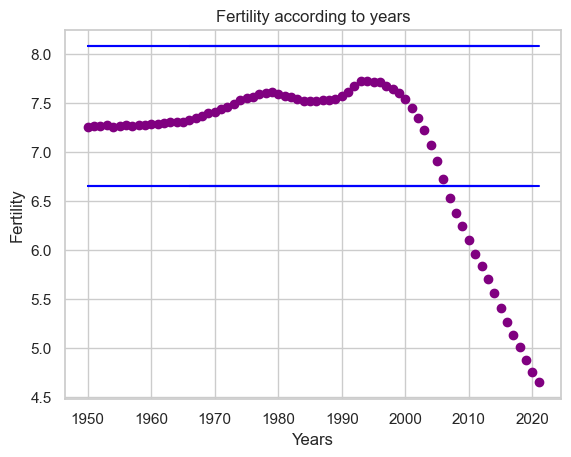

In [252]:
# We first reduce the dataset before removing outliers to keep only one country et one indicator
bronze_dataset = bronze_dataset[bronze_dataset.Code == 'AFG']
bronze_dataset = bronze_dataset[bronze_dataset.Indicator == 'Fertility']

# we plot the two limits 
plt.plot(bronze_dataset['Year'], bronze_dataset['Lower value'], color='blue')
plt.plot(bronze_dataset['Year'], bronze_dataset['Upper value'], color='blue')

#we plot the values of fertility for each year for Afghanistan with outliers
plt.scatter(bronze_dataset['Year'], bronze_dataset['Real value'], color='purple')

# we define the title and the labels of the axis 
plt.title('Fertility according to years')
plt.xlabel('Years')
plt.ylabel('Fertility')

plt.show()

So we can see that few values are outside the two limits, that's why we have removed them during the process of cleaning and removing outliers

Now we can plot the same graph but with the values from the dataset without ouliers to see that we have well removed the values outside the limits 

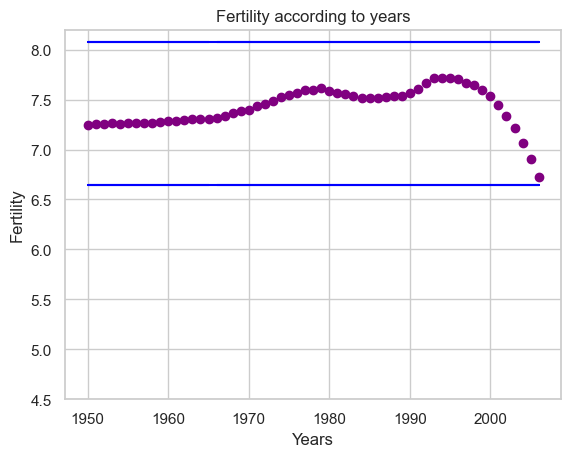

In [253]:
# We first reduce the dataset without outliers to keep only one country et one indicator
without_outliers = without_outliers[without_outliers.Code == 'AFG']
without_outliers = without_outliers[without_outliers.Indicator == 'Fertility']

# we plot the two limits 
plt.plot(without_outliers['Year'], without_outliers['Lower value'], color='blue')
plt.plot(without_outliers['Year'], without_outliers['Upper value'], color='blue')

#we plot the values of fertility for each year for Afghanistan without outliers
plt.scatter(without_outliers['Year'], without_outliers['Real value'], color='purple')

# we define the title and the labels of the axis 
plt.title('Fertility according to years')
plt.xlabel('Years')
plt.ylabel('Fertility')

plt.gca().set_ylim(4.5, 8.2)

plt.show()

On this graph, we can see that now there is only datas between the lower limit and the upper limits.
We have removed all the outliers !

# Box-Plots IQR

We can also plot the box plots of the fertility rate for Afghanistan with outliers and after removing outliers 

A box plot, is a graphical representation used to display the distribution and summary statistics of a dataset.   
It provides a concise way to visualize the spread, central tendency, and potential outliers within the data.

The box plot consists of five key components:

Minimum: The smallest value in the dataset.  
First Quartile (Q1): The 25th percentile, marking the lower boundary of the box.  
Median (Q2): The 50th percentile or the middle value of the dataset, represented by a line inside the box.  
Third Quartile (Q3): The 75th percentile, marking the upper boundary of the box.  
Maximum: The largest value in the dataset.  

The box itself represents the interquartile range (IQR), which is the range between the first and third quartiles (Q3 - Q1).  
It encompasses the middle 50% of the data. 

Extending from the box are lines called "whiskers." These whiskers typically extend to a maximum of 1.5 times the IQR from the quartiles. Data points beyond this range are considered outliers and are represented individually as points beyond the whiskers.

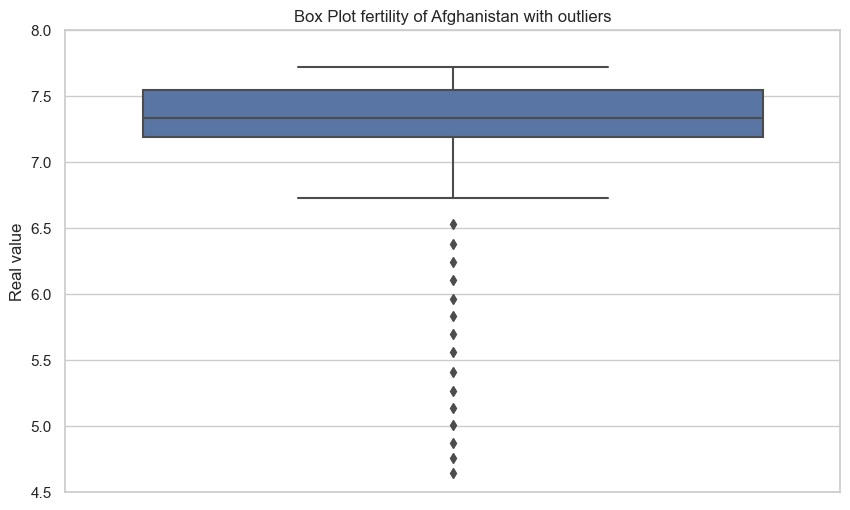

In [254]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
    
sns.boxplot(y =bronze_dataset['Real value'])                    
# Personnaliser les étiquettes et le titre
plt.title('Box Plot fertility of Afghanistan with outliers')
ax.set_ylim(4.5,8)
# Afficher le graphique
plt.show()


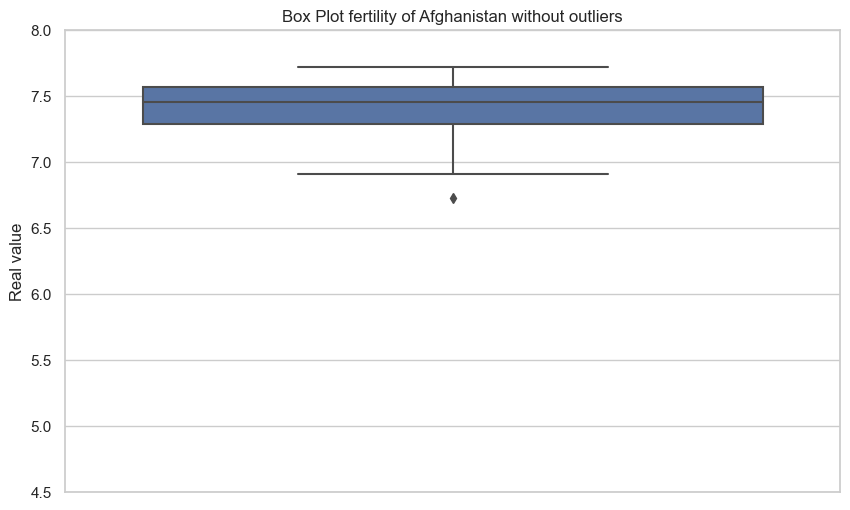

In [255]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
    
sns.boxplot(y =without_outliers['Real value'])                    
# Personnaliser les étiquettes et le titre
plt.title('Box Plot fertility of Afghanistan without outliers')
ax.set_ylim(4.5,8)
# Afficher le graphique
plt.show()

we can see that with the IQR method, we remove a lot of outliers

# <u> Remove outliers Z-score Method


Z score is also called standard score. This score helps to understand if a data value is greater or smaller than mean and how far away it is from the mean. More specifically, Z score tells how many standard deviations away a data point is from the mean

#### Z score = (x - mean) / std. deviation

It is estimated for a normal distribution that : 
68% of the data points lie between +/- 1 standard deviation.  
95% of the data points lie between +/- 2 standard deviation  
99.7% of the data points lie between +/- 3 standard deviation  

Removing outliers with z-score : 
If the z score of a data point is more than 3, it indicates that the data point is quite different from the other data points. Such a data point can be considered as an outlier.

#### Advantages of the Z-score method:

It is useful for detecting outliers in normal or near-normal distributions.
It provides a standardized measure of how far a value deviates from the mean, making it easier to compare different variables.

#### Limitations of the Z-score method:

It is sensitive to extreme values and can be influenced by them.
If the data distribution is not close to a normal distribution, outliers may not be properly identified using this method.

#  <u> step 1 : Load

In [256]:
# we open and read the merge table of all indicators 
bronze_dataset = pd.read_csv ('./data/all_indicators_table.csv')
bronze_dataset = bronze_dataset.drop(bronze_dataset.columns[0], axis = 1)
bronze_dataset = bronze_dataset.drop(bronze_dataset.columns[0], axis = 1)
bronze_dataset

,Code,Year,Deaths,LifeExpectancy,GenderInequality,GDP,Fertility,tertiary_education
0,AFG,1966,161659.0,35.5,NaN,500000224.0,7.3203,NaN
1,AFG,1967,162579.0,35.9,NaN,605919040.0,7.3387,NaN
2,AFG,1968,163573.0,36.4,NaN,572222720.0,7.3628,NaN
3,AFG,1969,164638.0,36.9,NaN,587037568.0,7.3887,NaN
4,AFG,1970,165430.0,37.4,NaN,728703360.0,7.3996,1.08
...,...,...,...,...,...,...,...,...
21407,ZWE,1945,NaN,NaN,NaN,41000000.0,NaN,NaN
21408,ZWE,1946,NaN,NaN,NaN,48000000.0,NaN,NaN
21409,ZWE,1947,NaN,NaN,NaN,59000000.0,NaN,NaN
21410,ZWE,1948,NaN,NaN,NaN,72000000.0,NaN,NaN


In [257]:
# we put all the indicators in one column 
bronze_dataset=(bronze_dataset.set_index(["Code", "Year"]).stack().reset_index(name='Value').rename(columns={'level_2':'Indicator'})) 

#we drop the country with a NaN value for Name and we reset the index
bronze_dataset = bronze_dataset.dropna(subset=['Code'])
bronze_dataset = bronze_dataset.sort_values(by=['Code', 'Indicator']).reset_index(drop=True)
bronze_dataset


,Code,Year,Indicator,Value
0,ABW,1950,Fertility,5.8010
1,ABW,1951,Fertility,5.7669
2,ABW,1952,Fertility,5.6950
3,ABW,1953,Fertility,5.6159
4,ABW,1954,Fertility,5.5295
...,...,...,...,...
66489,ZWE,1990,tertiary_education,1.8300
66490,ZWE,1995,tertiary_education,1.3200
66491,ZWE,2000,tertiary_education,0.5300
66492,ZWE,2005,tertiary_education,0.4400


We group the dataset by name of country and indicator 

In [258]:
bronze_dataset_group = bronze_dataset.groupby(['Code','Indicator'])

# <u>  step 2 : Computing the  Z-score

we compute the z score for each column of indicator

In [259]:
# we import the scipy module that includes modules for statistics 
from scipy import stats
all_columns = ['Deaths', 'LifeExpectancy', 'GenderInequality', 'GDP ', 'Fertility', 'tertiary_education']

# we compute the z score for each column of indicator
df_zscore = bronze_dataset_group.apply(stats.zscore,nan_policy='omit')
df_zscore = df_zscore.reset_index()
df_zscore = df_zscore.drop(df_zscore.columns[2], axis = 1)

#we add the year column
df_zscore['Year'] = bronze_dataset['Year'] 
df_zscore


,Code,Indicator,Year,Value
0,ABW,Fertility,1950,2.322425
1,ABW,Fertility,1951,2.295669
2,ABW,Fertility,1952,2.239252
3,ABW,Fertility,1953,2.177186
4,ABW,Fertility,1954,2.109392
...,...,...,...,...
66489,ZWE,tertiary_education,1990,1.161307
66490,ZWE,tertiary_education,1995,0.269936
66491,ZWE,tertiary_education,2000,-1.110816
66492,ZWE,tertiary_education,2005,-1.268117


Then we add to the bronze dataset the value of z-score

In [260]:
bronze_dataset['Z-score'] = df_zscore['Value'] 
bronze_dataset

,Code,Year,Indicator,Value,Z-score
0,ABW,1950,Fertility,5.8010,2.322425
1,ABW,1951,Fertility,5.7669,2.295669
2,ABW,1952,Fertility,5.6950,2.239252
3,ABW,1953,Fertility,5.6159,2.177186
4,ABW,1954,Fertility,5.5295,2.109392
...,...,...,...,...,...
66489,ZWE,1990,tertiary_education,1.8300,1.161307
66490,ZWE,1995,tertiary_education,1.3200,0.269936
66491,ZWE,2000,tertiary_education,0.5300,-1.110816
66492,ZWE,2005,tertiary_education,0.4400,-1.268117


#  <u>  step 3 : Remove outliers with z-score 

Now, we remove the outliers, indeed

In [261]:
# we delete the values > 3 (our treshold) and we keep the NaN values since we could fill it in an other part 
df_no_outliers = bronze_dataset[bronze_dataset['Z-score'] <= 3]
df_no_outliers

,Code,Year,Indicator,Value,Z-score
0,ABW,1950,Fertility,5.8010,2.322425
1,ABW,1951,Fertility,5.7669,2.295669
2,ABW,1952,Fertility,5.6950,2.239252
3,ABW,1953,Fertility,5.6159,2.177186
4,ABW,1954,Fertility,5.5295,2.109392
...,...,...,...,...,...
66489,ZWE,1990,tertiary_education,1.8300,1.161307
66490,ZWE,1995,tertiary_education,1.3200,0.269936
66491,ZWE,2000,tertiary_education,0.5300,-1.110816
66492,ZWE,2005,tertiary_education,0.4400,-1.268117


In [262]:
silver_dataset_score = df_no_outliers.drop(df_no_outliers.columns[4], axis = 1)
silver_dataset_score=silver_dataset_score.set_index(["Code", "Year"]).pivot(columns="Indicator", values="Value").reset_index()
silver_dataset_score=silver_dataset_score.rename(columns={0: 'index'})
silver_dataset_score

Indicator,Code,Year,Deaths,Fertility,GDP,GenderInequality,LifeExpectancy,tertiary_education
0,ABW,1950,NaN,5.8010,NaN,NaN,57.2,NaN
1,ABW,1951,NaN,5.7669,NaN,NaN,57.7,NaN
2,ABW,1952,NaN,5.6950,NaN,NaN,58.7,NaN
3,ABW,1953,NaN,5.6159,NaN,NaN,59.5,NaN
4,ABW,1954,NaN,5.5295,NaN,NaN,60.4,NaN
...,...,...,...,...,...,...,...,...
21232,ZWE,2017,26069.0,3.7064,NaN,0.532,60.7,NaN
21233,ZWE,2018,24648.0,3.6591,NaN,0.535,61.4,NaN
21234,ZWE,2019,24006.0,3.5994,NaN,0.533,61.3,NaN
21235,ZWE,2020,23533.0,3.5451,NaN,0.533,61.1,NaN


In [263]:
df_no_outliers.to_csv('./data/SilverDatasetZscore.csv')

We can also print all the rows with a z-score >3 to print the outliers 

In [264]:
df_with_outliers = bronze_dataset[bronze_dataset['Z-score'] > 3]
df_with_outliers

,Code,Year,Indicator,Value,Z-score
1770,ARG,2010,GDP,2.987639e+11,3.045872
1771,ARG,2011,GDP,3.482021e+11,3.636750
1772,ARG,2012,GDP,3.826000e+11,4.047867
1773,ARG,2013,GDP,3.991050e+11,4.245133
1774,ARG,2014,GDP,3.330694e+11,3.455886
...,...,...,...,...,...
65659,ZAF,2012,GDP,2.515643e+11,3.384396
65660,ZAF,2013,GDP,2.341530e+11,3.106619
66028,ZMB,2012,GDP,1.614463e+10,3.243165
66029,ZMB,2013,GDP,1.793963e+10,3.677133


# <u> step 4: Visual explanations with z-score  

We plot the graph of the z score for GDP for each year for the South AFrica before removing outliers

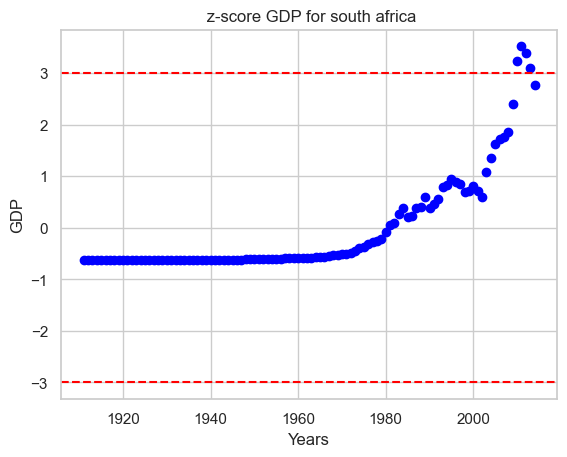

In [265]:
# We reduce the dataset without outliers to keep only one country
df = bronze_dataset[bronze_dataset.Code == 'ZAF']
df = df[df.Indicator == 'GDP ']

#we plot the values of tertiary_education for each year for Brazil with outliers
#plt.scatter(df['Year'], df['Value'], color='purple')

#we plot the zscore of teh dataset with outliers
plt.scatter(df['Year'], df['Z-score'], color='blue')

#we plot the limits for zscore 
plt.axhline(y=3, color='red', linestyle='--', label='y = 3')
plt.axhline(y=-3, color='red', linestyle='--', label='y = 3')

# we define the title and the labels of the axis 
plt.title(' z-score GDP for south africa')
plt.xlabel('Years')
plt.ylabel('GDP')

plt.show()

### We plot the graph of the z score for GDP for each year for the South AFrica after removing outliersrs
we can see that the point at the top has been removed

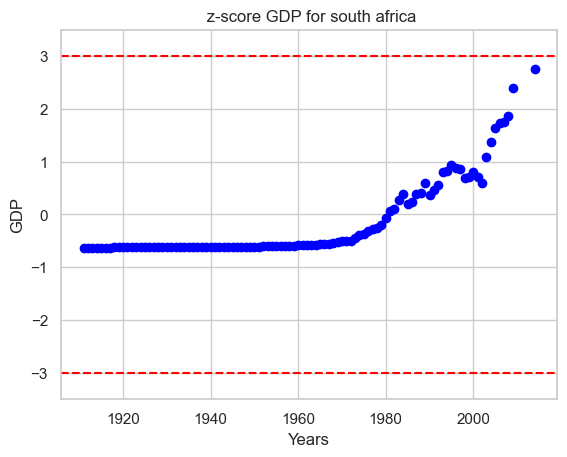

In [266]:
# We first reduce the dataset without outliers to keep only one country et one indicator
without_outliers = df_no_outliers[df_no_outliers.Code == 'ZAF']
without_outliers = without_outliers[without_outliers.Indicator == 'GDP ']

#we plot the values of tertiary_education for each year for Brazil without outliers
plt.scatter(without_outliers['Year'], without_outliers['Z-score'], color='blue')

#we plot the limits for zscore 
plt.axhline(y=3, color='red', linestyle='--', label='y = 3')
plt.axhline(y=-3, color='red', linestyle='--', label='y = 3')


# we define the title and the labels of the axis 
plt.title(' z-score GDP for south africa')
plt.xlabel('Years')
plt.ylabel('GDP')

plt.gca().set_ylim(-3.5, 3.5)

plt.show()

### We plot the graph of the values for GDP for each year for the South AFrica
in blue after removing   
in purple after removing  
we can see that the point at the top has been removed

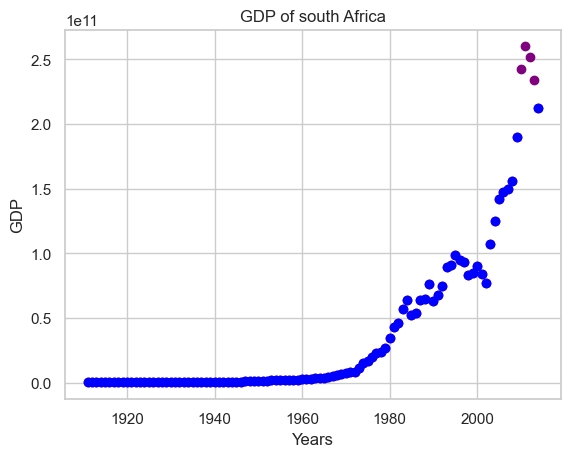

In [267]:
plt.scatter(df['Year'], df['Value'], color='purple')
plt.scatter(without_outliers['Year'], without_outliers['Value'], color='blue')

# we define the title and the labels of the axis 
plt.title('GDP of south Africa')
plt.xlabel('Years')
plt.ylabel('GDP')

plt.show()

# <u>  Box plot z-score

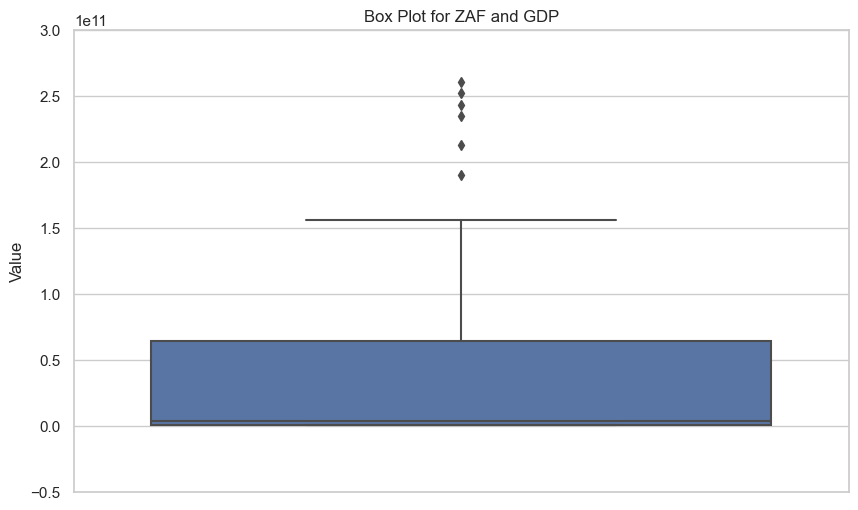

In [268]:
import seaborn as sns 

box = bronze_dataset[bronze_dataset.Code == 'ZAF']
box = box[box.Indicator == 'GDP ']


sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
    
sns.boxplot(y =box['Value'])                    
# Personnaliser les étiquettes et le titre
plt.title('Box Plot for ZAF and GDP')
ax.set_ylim(-0.5e11,3e11)
# Afficher le graphique
plt.show()

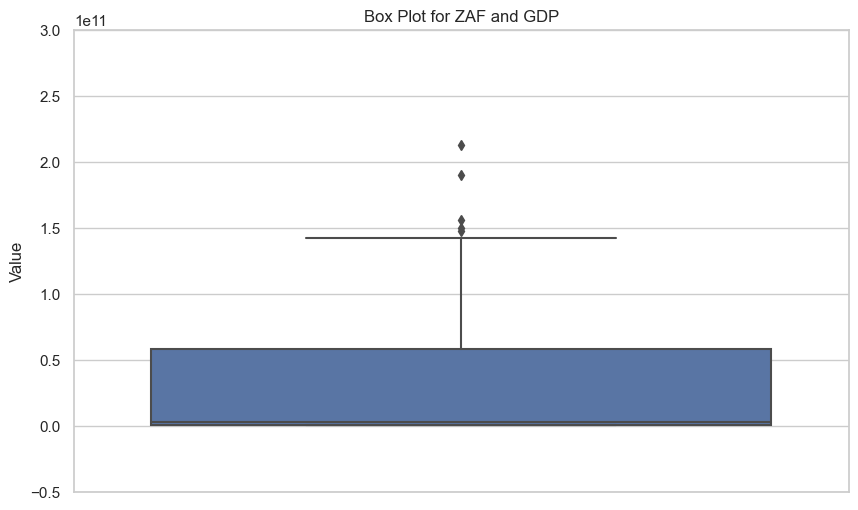

In [269]:
cleanbox = df_no_outliers[df_no_outliers.Code == 'ZAF']
cleanbox = cleanbox[cleanbox.Indicator == 'GDP ']

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
    
sns.boxplot(y =cleanbox['Value'])                    
# Personnaliser les étiquettes et le titre
plt.title('Box Plot for ZAF and GDP')
ax.set_ylim(-0.5e11,3e11)
# Afficher le graphique
plt.show()

the box plot is not the best chart to represent the outliers for this method